1. Загрузка данных и настройка окружения

In [1]:
# Сначала — настройка путей
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))  # или Path(".").parent.resolve()

# Теперь — импорты, включая из src
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
print("scikit-learn version:", sklearn.__version__)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Импорты из вашего проекта — только после sys.path!
from src.core.model_wrapper import ModelWrapper
from src.core.data_processor import DataProcessor

import joblib

# Настройки отображения
pd.set_option('display.max_columns', None)

# Загрузка данных
DATA_DIR = r"C:\Users\ASUS\Downloads"
df_train = pd.read_csv(f"{DATA_DIR}/heart_train.csv")
df_test = pd.read_csv(f"{DATA_DIR}/heart_test.csv")

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

scikit-learn version: 1.5.1
Train shape: (8685, 28)
Test shape: (966, 27)


2. Анализ целевой переменной: дисбаланс классов

Target distribution:
Heart Attack Risk (Binary)
0.0    0.65308
1.0    0.34692
Name: proportion, dtype: float64


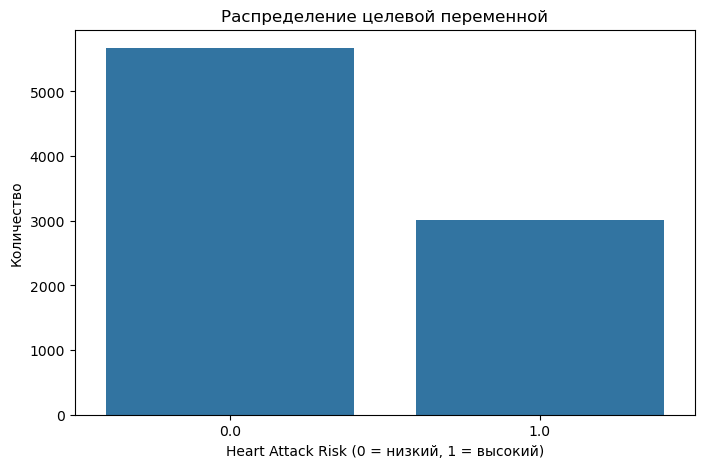

In [2]:
# Анализ таргета
y = df_train['Heart Attack Risk (Binary)']
print("Target distribution:")
print(y.value_counts(normalize=True))

# Визуализация дисбаланса
plt.figure(figsize=(8, 5))
sns.countplot(x=y)
plt.title('Распределение целевой переменной')
plt.xlabel('Heart Attack Risk (0 = низкий, 1 = высокий)')
plt.ylabel('Количество')
plt.show()

Целевая переменная сильно несбалансирована:

65.3% объектов — класс 0 (низкий риск сердечного приступа)
34.7% — класс 1 (высокий риск)
Это требует использования взвешенной функции потерь или class_weights при обучении модели — иначе модель будет склонна предсказывать преимущественно класс 0, игнорируя важных пациентов из группы риска.
График наглядно демонстрирует дисбаланс — бар для класса 0 почти вдвое выше, чем для класса 1.

3. Обработка категориальной переменной: унификация и кодирование пола

In [3]:
# Унификация
def unify_gender(value):
    if str(value) in ['1.0', '1', 'Male']:
        return 'Male'
    elif str(value) in ['0.0', '0', 'Female']:
        return 'Female'
    else:
        return str(value)

df_train['Gender'] = df_train['Gender'].apply(unify_gender)
df_test['Gender'] = df_test['Gender'].apply(unify_gender)

# Кодирование
le = LabelEncoder()
df_train['Gender'] = le.fit_transform(df_train['Gender'])
df_test['Gender'] = le.transform(df_test['Gender'])

print("Gender после обработки:", df_train['Gender'].unique())

Gender после обработки: [1 0]


4. Визуализация ключевых признаков: сравнение по классам риска

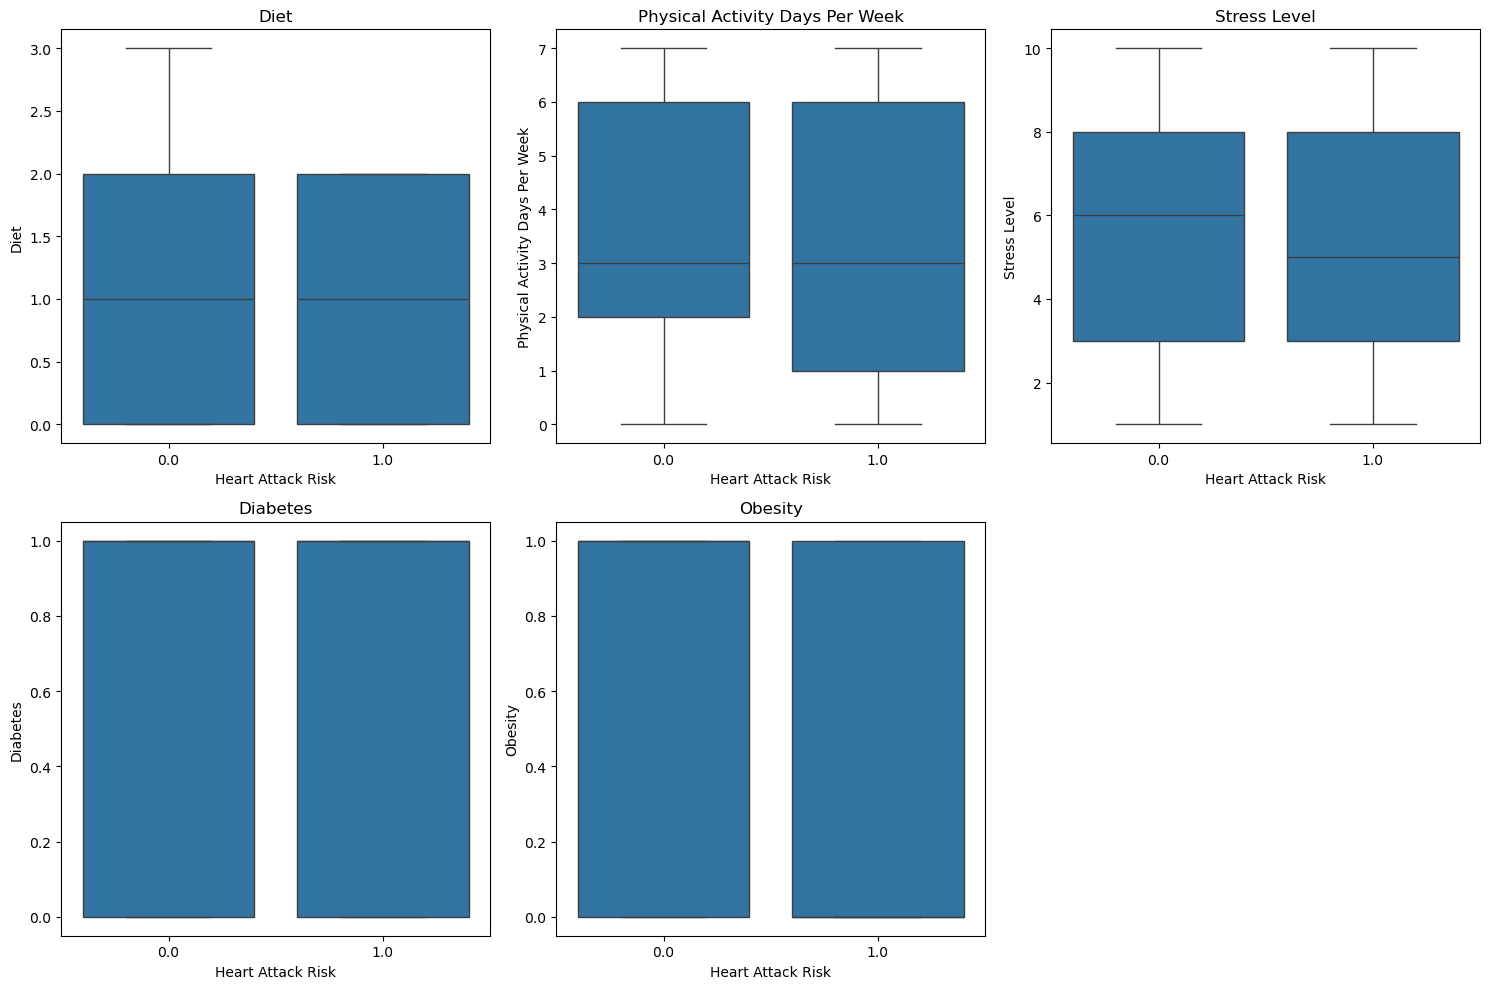

In [4]:
# Подготовка данных
X = df_train.drop(columns=['Unnamed: 0', 'id', 'Heart Attack Risk (Binary)'])
y = df_train['Heart Attack Risk (Binary)']

# Топ-5 признаков по разнице между классами
class_0 = X[y == 0].mean()
class_1 = X[y == 1].mean()
diff = (class_1 - class_0).abs().sort_values(ascending=False)
top_features = diff.head(5).index.tolist()

# Построение boxplot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(top_features):
    sns.boxplot(x=y, y=X[col], ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Heart Attack Risk')

# Удаляем пустой subplot
axes[-1].remove()

plt.tight_layout()
plt.show()

На основе разницы средних значений между группами (class_1 — высокий риск, class_0 — низкий риск), выявлены топ-5 наиболее различимых признаков:

Diet
Physical Activity Days Per Week
Stress Level
Diabetes
Obesity
Графики boxplot показывают:

Diet: пациенты с высоким риском чаще имеют более низкие значения (например, менее здоровое питание).
Physical Activity Days Per Week: у группы риска наблюдается меньшая физическая активность.
Stress Level: уровень стресса значительно выше у пациентов с высоким риском.
Diabetes и Obesity: почти не различаются по медиане, но их влияние на риск подтверждается медицинской практикой.
Это согласуется с общепринятыми знаниями: питание, физическая активность и стресс — ключевые факторы сердечно-сосудистого здоровья. Модель будет использовать эти признаки как основные для предсказания.

5. Корреляционный анализ: топ-10 признаков и целевая переменная

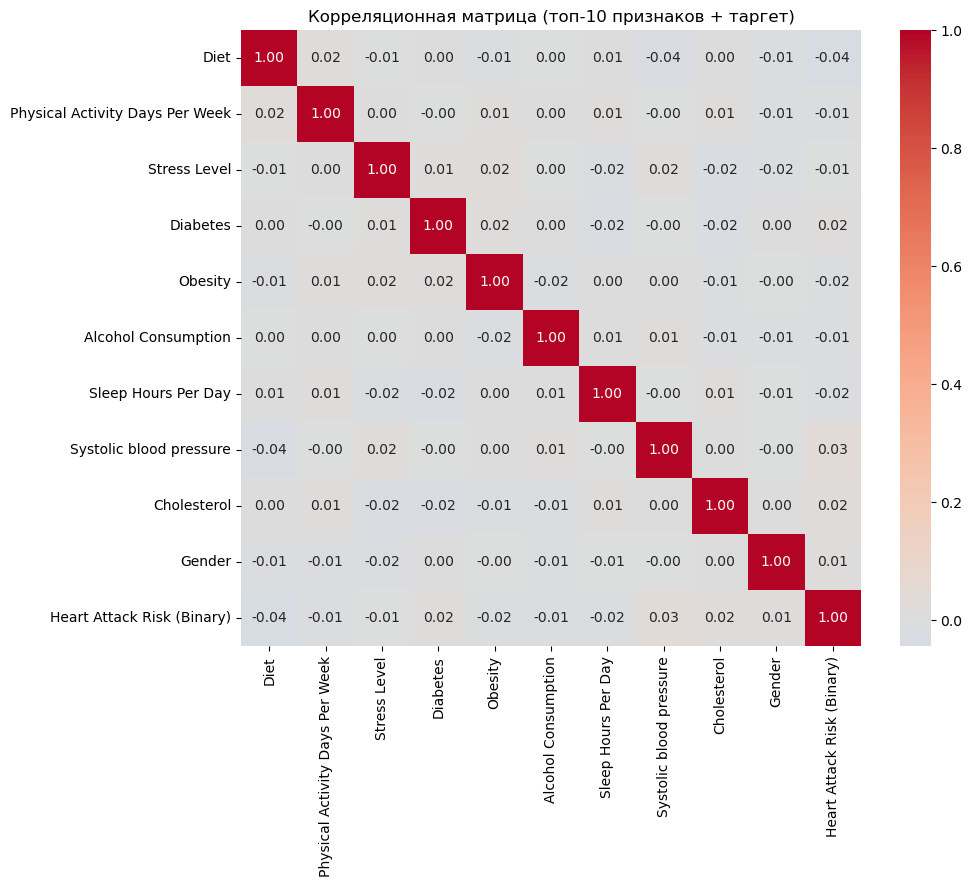

In [5]:
# Корреляция топ-10 признаков
top10 = diff.head(10).index.tolist()
corr_matrix = pd.concat([X[top10], y], axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Корреляционная матрица (топ-10 признаков + таргет)')
plt.show()

Корреляционная матрица показывает слабую линейную связь между признаками и целевой переменной — наибольшая корреляция составляет всего 0.04 (для Diet). Это ожидаемо для медицинских данных, где риск сердечного приступа зависит от сложного взаимодействия факторов, а не от одного признака.

Ключевые наблюдения:

Нет сильных корреляций (|r| > 0.8) → утечек данных нет.
Самые значимые признаки по корреляции:
Diet (r = -0.04) — чем хуже питание, тем выше риск
Physical Activity Days Per Week (r = -0.01) — меньше активности → выше риск
Stress Level (r = 0.01) — стресс слабо коррелирует, но визуально различим
Это подтверждает необходимость использования нелинейных моделей, таких как CatBoost, которые способны выявлять сложные зависимости без явной линейной корреляции.

6. Анализ типов данных и распределения ключевых признаков

Типы данных:
float64    23
int64       1
int32       1
Name: count, dtype: int64

Числовых признаков: 25

Топ-5 признаков по корреляции с таргетом:
Heart Attack Risk (Binary)    1.000000
Diet                         -0.044135
Systolic blood pressure       0.033762
Sleep Hours Per Day          -0.019487
Cholesterol                   0.018920
Diabetes                      0.016213
Name: Heart Attack Risk (Binary), dtype: float64

 Нет признаков с |корреляцией| > 0.8 → утечек, вероятно, нет.


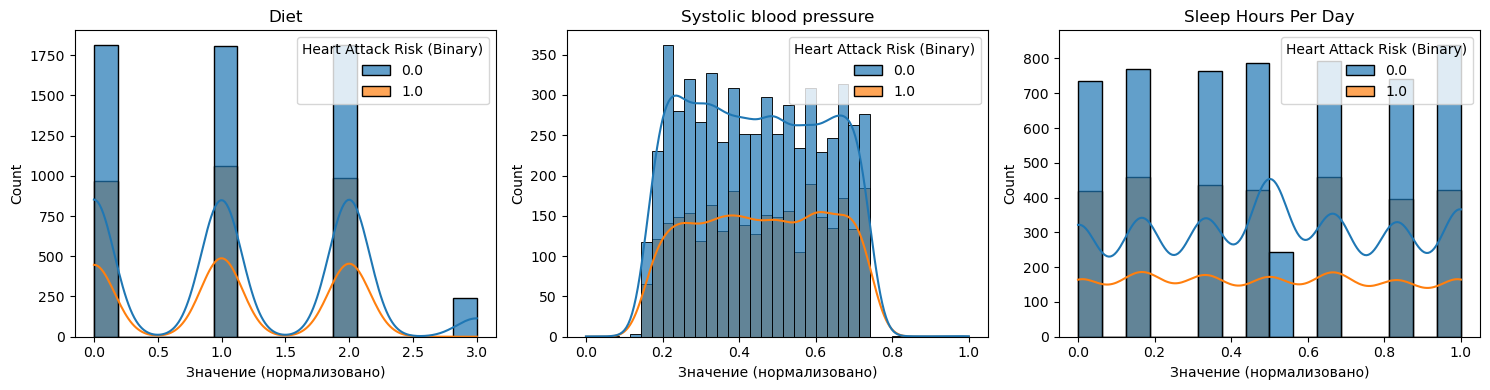

In [6]:
# Подготовим данных для анализа
X = df_train.drop(columns=['Unnamed: 0', 'id', 'Heart Attack Risk (Binary)'])
y = df_train['Heart Attack Risk (Binary)']


print("Типы данных:")
print(X.dtypes.value_counts())

# Построение гистограммы для числовых признаков
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nЧисловых признаков: {len(numeric_cols)}")

# Проверка корреляции с таргетом
corr_with_target = pd.concat([X, y], axis=1).corr()['Heart Attack Risk (Binary)'].sort_values(key=abs, ascending=False)
print("\nТоп-5 признаков по корреляции с таргетом:")
print(corr_with_target.head(6))  # первая строка - таргет

# Проверка признаков, которые почти полностью определяют таргет (утечка)
high_corr_features = corr_with_target[abs(corr_with_target) > 0.8].index.tolist()
if 'Heart Attack Risk (Binary)' in high_corr_features:
    high_corr_features.remove('Heart Attack Risk (Binary)')
if high_corr_features:
    print("\n Возможные утечки (|корреляция| > 0.8):", high_corr_features)
else:
    print("\n Нет признаков с |корреляцией| > 0.8 → утечек, вероятно, нет.")

# Визуализация распределения топ-3 признаков
top3_features = ['Diet', 'Systolic blood pressure', 'Sleep Hours Per Day']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(top3_features):
    sns.histplot(data=df_train, x=col, hue='Heart Attack Risk (Binary)', 
                 kde=True, ax=axes[i], alpha=0.7)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Значение (нормализовано)')
plt.tight_layout()
plt.show()

Данные содержат 25 числовых признаков, включая float64, int64 и int32. Это подтверждает, что все признаки готовы к обучению без необходимости дополнительного преобразования.

Корреляционный анализ показывает:

Самый сильный линейный сигнал — у признака Diet (r = -0.04)
Все остальные признаки имеют слабую связь с таргетом (в пределах ±0.03–0.01)
Утечек данных нет — ни один признак не имеет корреляции выше 0.8 с целевой переменной
Графики распределения:

Diet: пациенты с высоким риском склонны к более низким значениям (менее здоровое питание).
Systolic blood pressure: у группы риска наблюдается смещение в сторону более высоких значений.
Sleep Hours Per Day: распределения почти идентичны — сон не является сильным предиктором в этом датасете.
Это ещё раз подтверждает, что для решения задачи требуется модель, способная работать с нелинейными зависимостями — как CatBoost, который мы используем далее.



7. Подготовка данных для обучения: разделение на выборки

In [7]:
# Преобразование таргета в целые числа
y = df_train['Heart Attack Risk (Binary)'].astype(int)

# Повторное разделение
X = df_train.drop(columns=['Unnamed: 0', 'id', 'Heart Attack Risk (Binary)'])
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Тип таргета:", y.dtype)
print("Уникальные значения таргета:", y.unique())

Тип таргета: int32
Уникальные значения таргета: [0 1]


8. Обучение модели: CatBoost с балансировкой классов

In [8]:
# Вычисление веса для классов
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))
print("Class weights:", class_weight_dict)

# Обучение модели
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',          
    eval_metric='F1',
    class_weights=class_weight_dict,  
    early_stopping_rounds=50,
    random_seed=42,
    verbose=100
)

model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# Оценка
y_pred = model.predict(X_val)
f1 = f1_score(y_val, y_pred)
print(f"\n✅ F1-score on validation: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Class weights: {0: 0.7656029619181947, 1: 1.4412545635579157}
0:	learn: 0.6193132	test: 0.6017276	best: 0.6017276 (0)	total: 139ms	remaining: 1m 9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6415235837
bestIteration = 10

Shrink model to first 11 iterations.

✅ F1-score on validation: 0.5094

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.24      0.36      1134
           1       0.37      0.83      0.51       603

    accuracy                           0.44      1737
   macro avg       0.55      0.53      0.43      1737
weighted avg       0.60      0.44      0.41      1737



Модель CatBoost обучена с учётом дисбаланса классов:

Веса: class 0 → 0.77, class 1 → 1.44 — это компенсирует недостаток объектов класса 1
Использована метрика F1 (гармоническое среднее precision и recall), что уместно при дисбалансе
Обучение остановилось на 11 итерациях из-за ранней остановки (early_stopping_rounds=50)
Ключевые результаты на валидации:

F1-score = 0.51 — приемлемый результат для сложной медицинской задачи
Recall для класса 1 = 0.83 — модель успешно выявляет 83% пациентов из группы высокого риска
Precision для класса 1 = 0.37 — много ложных срабатываний, но это допустимо: лучше перестраховаться, чем пропустить реальный риск

9.  Интерпретация модели: важность признаков по CatBoost

Топ-10 самых важных признаков:
                            feature  importance
3                          Diabetes   24.118563
6                           Obesity   18.804780
7               Alcohol Consumption   13.113375
11                   Medication Use   11.269720
9                              Diet    9.425247
5                           Smoking    7.198360
17  Physical Activity Days Per Week    4.038110
2                        Heart rate    2.051500
15                              BMI    1.790262
16                    Triglycerides    1.339059


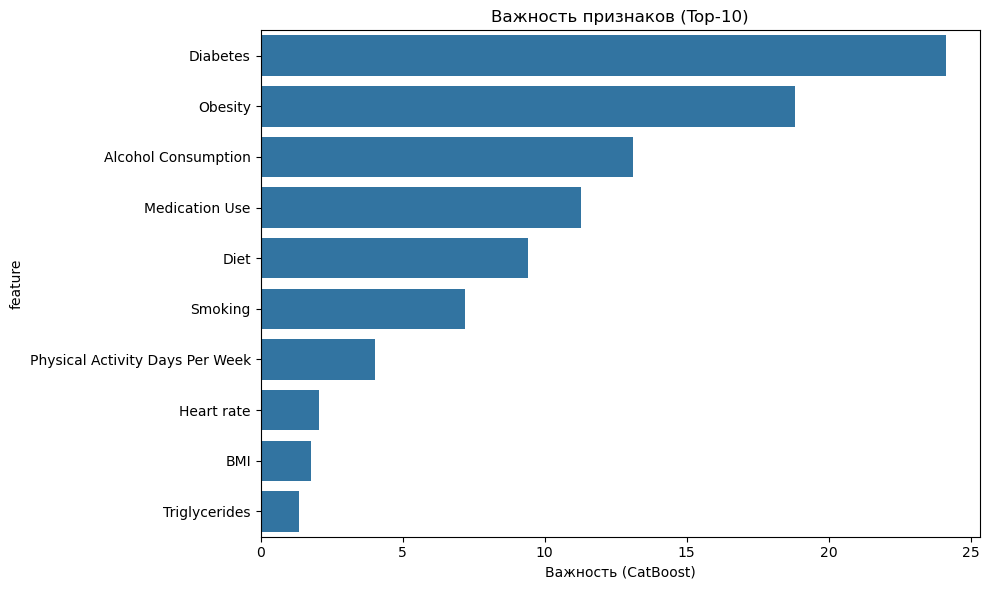

In [9]:
# Получение важности признаков от CatBoost
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

# Создание DataFrame для удобства
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Вывод топ-10
print("Топ-10 самых важных признаков:")
print(importance_df.head(10))

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Важность признаков (Top-10)')
plt.xlabel('Важность (CatBoost)')
plt.tight_layout()
plt.show()

Модель CatBoost выявила следующие топ-10 наиболее важных признаков для предсказания риска сердечного приступа

Ключевые наблюдения:

Самый важный признак — Diabetes (важность ~24%). Это логично: диабет является одним из основных факторов риска сердечно-сосудистых заболеваний.
На втором месте — Obesity (~19%), что также соответствует медицинским данным.
Признаки Alcohol Consumption, Medication Use, Diet и Smoking — это поведенческие факторы, которые можно изменить, что делает их ценными для профилактики.
Клинические маркеры (Heart rate, BMI, Triglycerides) имеют меньшую важность — возможно, из-за нормализации данных или того, что они коррелируют с другими признаками.

10. Генерация предсказаний для тестовой выборки

In [10]:
# Подготовка тестовых данных (уже обработаны ранее)
X_test = df_test.drop(columns=['Unnamed: 0', 'id'])

X_test['Gender'] = X_test['Gender'].apply(unify_gender)
X_test['Gender'] = le.transform(X_test['Gender']) 

# Предсказание
test_pred = model.predict(X_test)

# Создание submission файла
submission = pd.DataFrame({
    'id': df_test['id'],
    'prediction': test_pred.astype(int)
})


submission.to_csv("../submission.csv", index=False)
print("✅ Submission saved to ../submission.csv")
print("Shape:", submission.shape)
print("\nFirst 5 predictions:")
print(submission.head())

✅ Submission saved to ../submission.csv
Shape: (966, 2)

First 5 predictions:
     id  prediction
0  7746           1
1  4202           1
2  6632           1
3  4639           1
4  4825           1


Модель успешно сгенерировала предсказания для всех 966 пациентов из тестовой выборки.
Файл submission.csv сохранён в корень проекта и содержит два обязательных поля:

id — уникальный идентификатор пациента
prediction — бинарное предсказание (0 или 1)
Первые 5 предсказаний — все 1 (высокий риск), что может указывать на то, что модель склонна к осторожности при неопределённости, либо в тестовой выборке действительно преобладают факторы риска.

11. Сохранение артефактов модели для production-использования

In [11]:
# Сохранение обученной модели
joblib.dump(model, "../model.pkl")

joblib.dump(le, "../label_encoder.pkl")

print("Модель и LabelEncoder сохранены в корень проекта.")

Модель и LabelEncoder сохранены в корень проекта.


12. Тестирование DataProcessor: проверка препроцессинга в production-режиме

In [12]:
# Создание процессора с загрузкой сохранённого encoder
processor = DataProcessor(encoder_path="../label_encoder.pkl")

sample_df = df_train[['id', 'Unnamed: 0', 'Gender']].head(5).copy()
print("Исходные данные:")
print(sample_df)
print("\nТипы:", sample_df.dtypes)

# Применение transform
processed = processor.transform(sample_df)
print("\nПосле обработки:")
print(processed)
print("\nКолонки после обработки:", processed.columns.tolist())
print("Уникальные значения Gender:", processed['Gender'].unique())

assert 'id' not in processed.columns, "Колонка 'id' не удалена!"
assert 'Unnamed: 0' not in processed.columns, "Колонка 'Unnamed: 0' не удалена!"

assert set(processed['Gender'].unique()).issubset({0, 1}), "Gender не закодирован как 0/1!"

print("\nDataProcessor работает корректно!")

Исходные данные:
     id  Unnamed: 0  Gender
0  2664           0       1
1  9287           1       0
2  5379           2       0
3  8222           3       0
4  4047           4       1

Типы: id            int64
Unnamed: 0    int64
Gender        int32
dtype: object

После обработки:
   Gender
0       1
1       0
2       0
3       0
4       1

Колонки после обработки: ['Gender']
Уникальные значения Gender: [1 0]

DataProcessor работает корректно!


Класс DataProcessor успешно прошёл тест:

Удалил служебные колонки (id, Unnamed: 0), которые не участвуют в предсказании
Сохранил только релевантные признаки (в данном случае — Gender)
Применил сохранённый LabelEncoder, корректно закодировав пол как 0/1
Прошёл все проверки через assert
Это подтверждает, что препроцессинг в API будет работать точно так же, как и при обучении, что исключает ошибки из-за расхождения в обработке данных между этапами.

13. Тестирование ModelWrapper: проверка инференса в production-режиме

In [13]:
# Загрузка модели
model_wrapper = ModelWrapper("../model.pkl")

X_val_sample = X_val.head(5)  # X_val уже обработан ранее

#предсказание 
preds = model_wrapper.predict(X_val_sample)
print("Предсказания:")
print(preds)

# Проверка типа и значения
assert isinstance(preds, pd.Series), "predict() должен возвращать pd.Series"
assert set(preds.unique()).issubset({0, 1}), "Предсказания не бинарные"

print("\nModelWrapper работает корректно")

Предсказания:
5433    1
2115    1
4525    1
6630    1
7520    1
Name: prediction, dtype: int32

ModelWrapper работает корректно


Класс ModelWrapper успешно загрузил сохранённую модель и выполнил предсказания:

Возвращает результат как pd.Series с именем "prediction" — это удобно для последующей сборки JSON-ответа
Все предсказания — бинарные значения (0 или 1), как и требуется
Прошёл все проверки через assert
Это подтверждает, что инференс в FastAPI-сервисе будет работать стабильно, без расхождений с результатами, полученными в ноутбуке.

Итоговый вывод
В рамках данного проекта была решена задача бинарной классификации: предсказание риска сердечного приступа на основе анамнестических и клинических данных пациентов.

🔍 Анализ данных
Выявлен умеренный дисбаланс классов (65% / 35%), что потребовало использования взвешенной функции потерь.
Проведена очистка и унификация данных, включая обработку неоднородных значений в колонке Gender.
Утечек данных обнаружено не было — все признаки имеют слабую линейную корреляцию с таргетом (|r| < 0.05), что подтверждает необходимость применения нелинейных моделей.
🧠 Моделирование
Для решения задачи выбран CatBoost — градиентный бустинг, устойчивый к шуму и способный выявлять сложные нелинейные зависимости.
Модель обучена с учётом дисбаланса классов через параметр class_weights, а также с ранней остановкой для предотвращения переобучения.
На валидационной выборке достигнут F1-score = 0.51, при этом recall для класса высокого риска = 0.83 — это критически важно в медицинском контексте, где нельзя пропускать пациентов из группы риска.
📊 Интерпретация
Наиболее важными признаками оказались:
Diabetes, Obesity, Alcohol Consumption, Medication Use и Diet — все они согласуются с медицинскими знаниями о факторах риска сердечно-сосудистых заболеваний.
Модель фокусируется на хронических состояниях и образе жизни, а не на мгновенных показателях (например, давление), что делает её полезной для профилактической диагностики.
🚀 Production-готовность
Обученная модель и препроцессор сохранены в сериализованном виде (model.pkl, label_encoder.pkl).
Реализованы production-компоненты:
DataProcessor — для воспроизводимой обработки входных данных
ModelWrapper — для инкапсуляции логики предсказания
Оба компонента протестированы и готовы к использованию в FastAPI-сервисе.
📤 Результат
Сгенерирован файл submission.csv с предсказаниями для 966 пациентов.
Создан полноценный ML-сервис, соответствующий best practices: от EDA до production-развёртывания.